In [3]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display
from IPython import display
import matplotlib.pyplot
import skimage.color
import skimage.transform

# HW 5 
### EE290T Fall 2018



## Part 1 - Low rank texture recovery 

In low-rank texture recovery, we measure $Y$: 

$$ \boldsymbol Y =  \boldsymbol L + \boldsymbol S $$

Where $\boldsymbol L$ is a low rank texture that is corrupted by a sparse perturbation, $\boldsymbol S$. Given $\boldsymbol Y$, we hope to recover $\boldsymbol L$. 

First, let's load in some sample low rank texture images, $\boldsymbol L$, and see if they actually are low rank. 
 

In [4]:
img_list = {0: 'texture_matfiles/circle_texture.mat',
            1: 'texture_matfiles/circsquare_texture.mat',
            2: 'texture_matfiles/hex_texture.mat',
            3: 'texture_matfiles/flower.jpg'}

In [70]:
img_num = 3

def read_img(img_num):
    if img_num == 3:
        image = matplotlib.pyplot.imread(img_list[img_num])
        X = skimage.color.rgb2gray(image)
    else: 
        image = scipy.io.loadmat(img_list[img_num])
        X = image['J'].astype('float32')
        X = X/255.
    return X

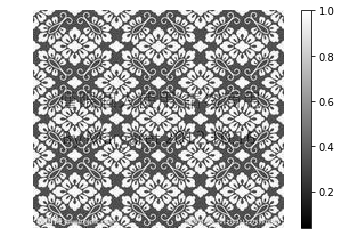

In [71]:
X = read_img(3)
m,n = X.shape

plt.imshow(X, cmap = 'gray'); plt.axis('off'); plt.colorbar()

__(a)__ Plot the singular vaues of the image and the rank-r approximation of 2-3 of the above texture images.  Approximately what is the rank of each of the texture images you've selected?  


In [79]:
def svd_plot(X):
    U,s,V = np.linalg.svd(X,full_matrices=False)
    r = 0
    while s[r] >=5:
        r+=1
    plt.figure()
    plt.plot(s,color = 'r', linestyle='-',linewidth = 2)
    plt.xlabel("Rank r:"+"approximation "+str(r))
    plt.ylabel("Singular values")
    plt.title("Singular values of the image: "+img_list[img_num])
    plt.show()
    return None

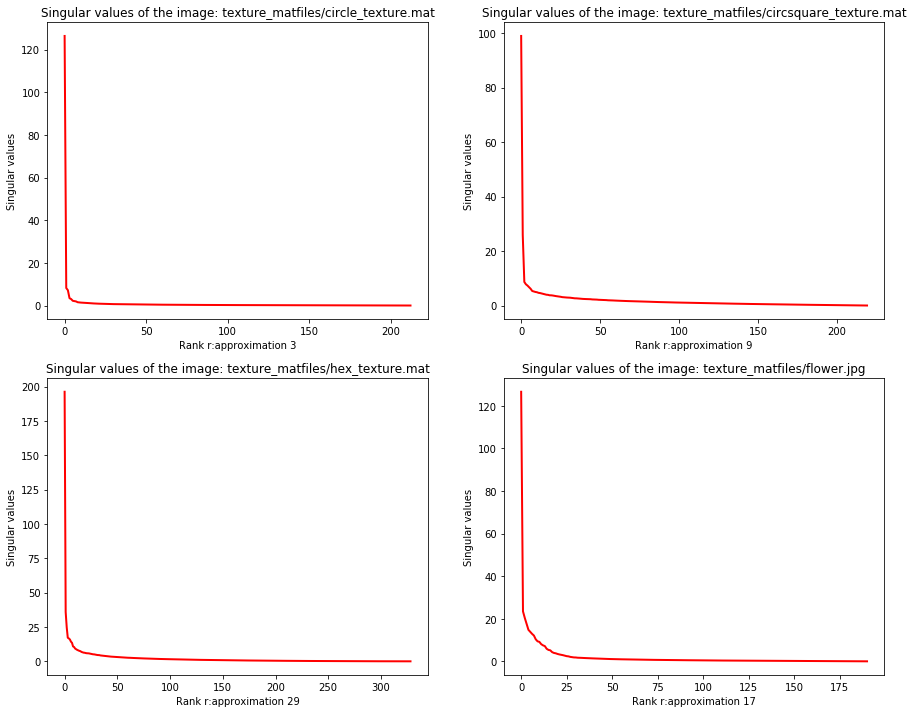

In [62]:
"""Your code here"""
plt.figure(figsize=(15,12))

for img_num in range(4):
    X = read_img(img_num)
    U,s,V = np.linalg.svd(X,full_matrices=False)
    r = 0
    while s[r] >=5:
        r+=1
    S = np.diag(s)
#     plt.figure()
    plt.subplot(2,2,img_num+1)
    plt.plot(s,color = 'r', linestyle='-',linewidth = 2)
    plt.xlabel("Rank r:"+"approximation "+str(r))
    plt.ylabel("Singular values")
    plt.title("Singular values of the image: "+img_list[img_num])
plt.show()

In [63]:
appro_r = 3
def r_approximation(X,appro_r):
    U,s,V = np.linalg.svd(X,full_matrices=False)
    S = np.diag(s)
    Im = U[:,0:appro_r].dot(S[0:appro_r,0:appro_r].dot(V[0:appro_r,:]))
    return Im

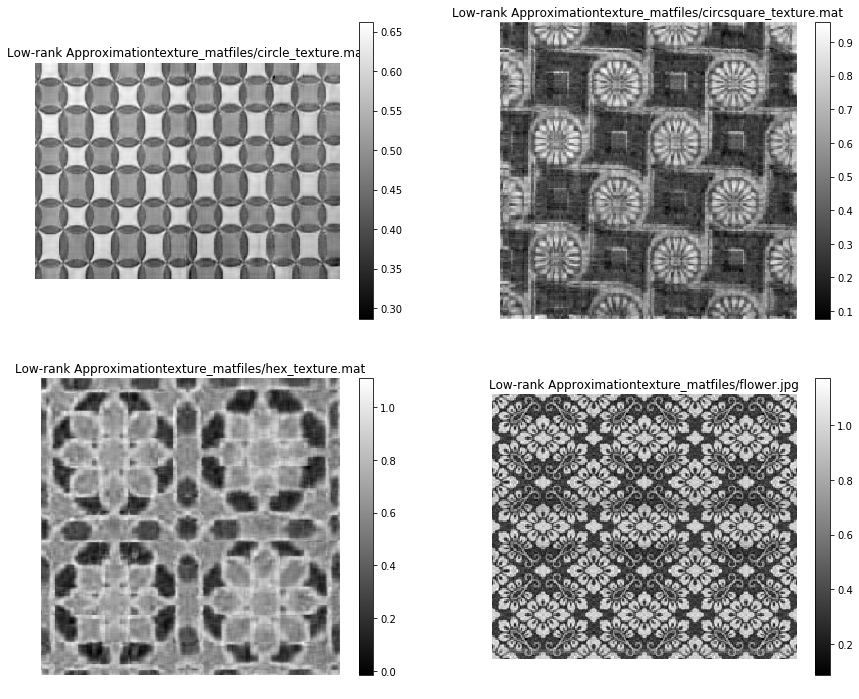

In [68]:
"""Your code here"""
rank = 15 # Define the rank of low-rank approximation
plt.figure(figsize=(15,12))
for img_num in range(4):
    X = read_img(img_num)
    Im = r_approximation(X,rank)
#     r = 0
#     while s[r] >=5:
#         r+=1
#     S = np.diag(s)
# #     plt.figure()
    plt.subplot(2,2,img_num+1)
    plt.imshow(Im,cmap="gray"); plt.axis('off'); plt.colorbar()
#     plt.xlabel("Rank r:"+"approximation "+str(r))
#     plt.ylabel("Singular values")
    plt.title("Low-rank Approximation"+img_list[img_num])
plt.show()

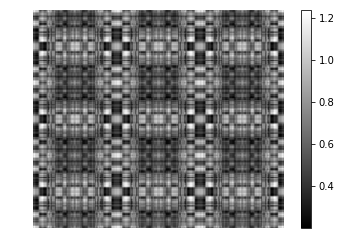

In [36]:
plt.imshow(Im,cmap="gray"); plt.daxis('off'); plt.colorbar()

In [69]:
"""Your code here, showing rank-r approximation (image)"""

'Your code here, showing rank-r approximation (image)'

Now we'll add a sparse corruption, $L$ to the image. 

In [72]:
p = 0.1
mask = np.random.rand(m,n) <= p
Y = X.copy()
Y[mask] = 5*np.random.rand(np.count_nonzero(mask))


# Center image around 0

X = (X-0.5)/0.5
Y = (Y-0.5)/0.5

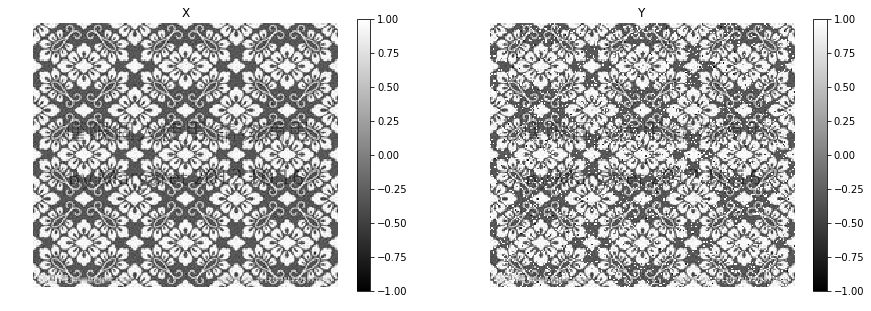

In [93]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('X');
plt.subplot(1,2,2), plt.imshow(Y, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Y');

__(b)__ Take the SVD of the measurement and plot the rank-r approximation of $Y$ with the added corruption.  Describe how the singular values and the rank-r approximation is different from before.  Is this still low rank?

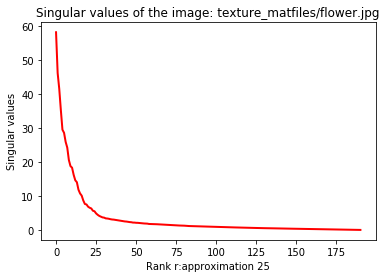

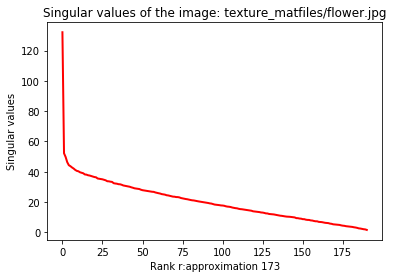

'Your code here, showing rank-r approximation (image)'

In [82]:
svd_plot(X)
svd_plot(Y)
"""Your code here"""
"""Your code here, showing rank-r approximation (image)"""

__Conclusion__: As shown in the results,sparse corrupted low-rank matrix is not of low-rank, with approximated rank much larger than the one without corruption.

In [87]:
Im_X = r_approximation(X,15)
Im_Y = r_approximation(Y,15)

Text(0.5,1,'low-rank approximation with corruption')

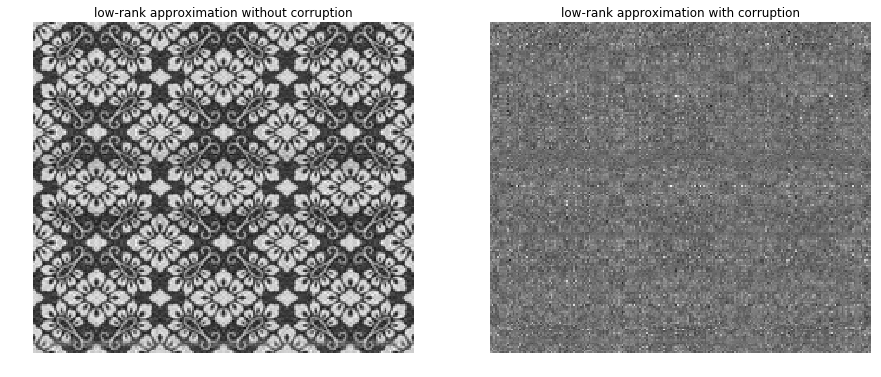

In [92]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1);plt.imshow(Im_X,cmap='gray');plt.axis("off");plt.title("low-rank approximation without corruption")
plt.subplot(1,2,2);plt.imshow(Im_Y,cmap='gray');plt.axis("off");plt.title("low-rank approximation with corruption")

One way to recover the low rank texture is to use ADMM.  Here's the problem formulation (based on eq 5.2.4):

$$ \text{minimize} \quad \|L\|_* + \lambda \|S\|_1 $$
$$ \text{subject to} \qquad \ \  L+S=Y  $$

Here, $Y$ is the corrupted mxn texture image.  We are interested in finding $S$ and $L$ given $Y$. 


We can solve this using principle component pursuit by ADMM (Algorithm 5.1), reproduced below for convenieve:

__Input:__ $\boldsymbol S_0 = \boldsymbol \Lambda_0, \mu>0$ <br>
__while__ not converged __do__ <br>
> Compute $\boldsymbol L_{k+1} = D_{1/\mu}(\boldsymbol Y - \boldsymbol S_k + \mu^{-1}\boldsymbol \Lambda_k)$ <br>
Compute $\boldsymbol S_{k+1} = S_{\lambda/\mu}(\boldsymbol Y - \boldsymbol L_{k+1} + \mu^{-1}\boldsymbol \Lambda_k)$ <br>
Compute $\boldsymbol \Lambda_{k+1} = \Lambda_{k} + \mu(\boldsymbol Y - \boldsymbol L_{k+1} - \boldsymbol S_{k+1})$ <br>

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

As stated in the book, the shrinkage operators, $S$ and $D$ have simple closed form solutions:

$$ S_\tau [x] = \text{sgn}(x)\text{max}(|x| - \tau,0) $$
$$ D_\tau [x] = US_\tau (\Sigma)V^* $$


__(c)__ Write a function to do robust PCA using ADMM.  Feed in your corrupted image, $Y$, and output the recovered low rank texture, $L$ and sparse corruption matrix $S$. Plot the recovered images, $L$ and $S$. 


In [90]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)
def soft_decomp(X,l):
    U,s,V = np.linalg.svd(X,full_matrices=False)
    S = soft_thresh(np.diag(s),l)
    return U.dot(S.dot(V))

In [124]:
""" Your code here"""
def robust_PCA(Y,u,lam,ite):
    S = np.zeros(Y.shape)
    A = np.zeros(Y.shape)
    for i in range(ite):
#         print(i)
        Lk = soft_decomp(Y-S+(1/u)*A,1/u)
        Sk = soft_thresh(Y-Lk+(1/u)*A,lam/u)
#         print(np.max(abs(Sk)))
        Ak = A + u*(Y-Lk-Sk)
        S = Sk
        L = Lk
        A = Ak
    return L, S


In [108]:
L,S = robust_PCA(Y,1,0.1,1000)

In [104]:
np.max(abs(S))

9.254170696152778

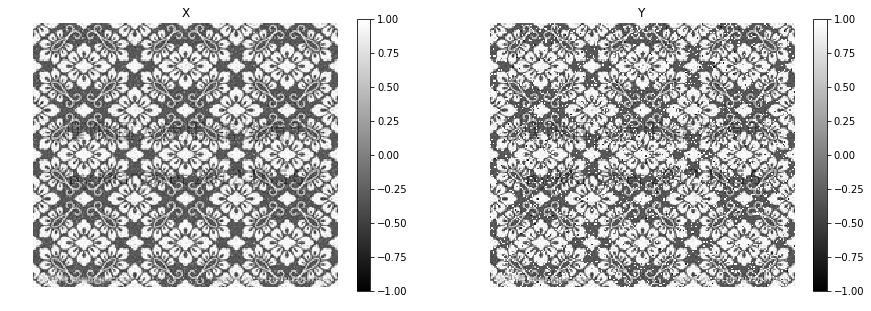

In [106]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('X');
plt.subplot(1,2,2), plt.imshow(Y, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Y');

__(d)__ For 2-3 of the textures above, increase the parameter $p$ (corruption amount) until ADMM fails to recover the low rank texture.  How high can you make $p$ before this happens? 


0.01


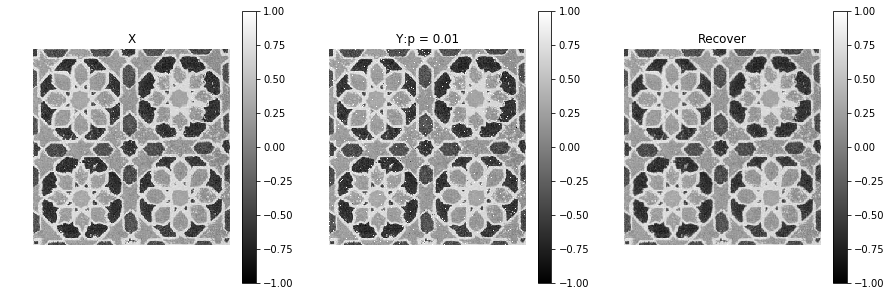

0.1


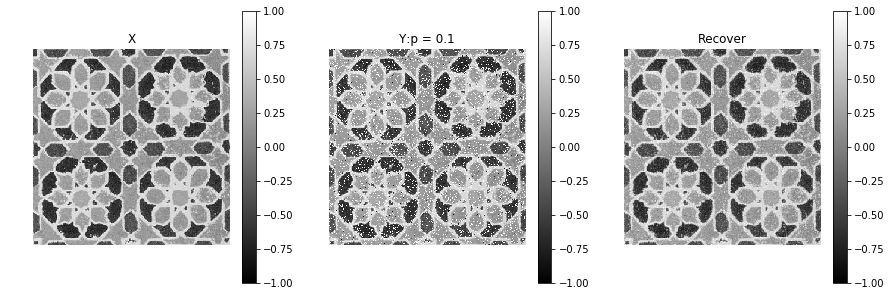

0.2


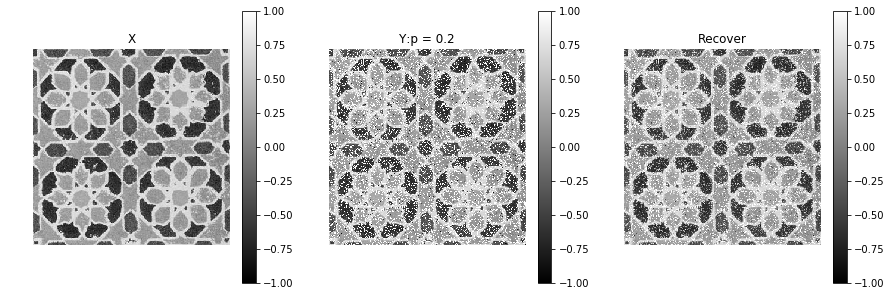

0.4


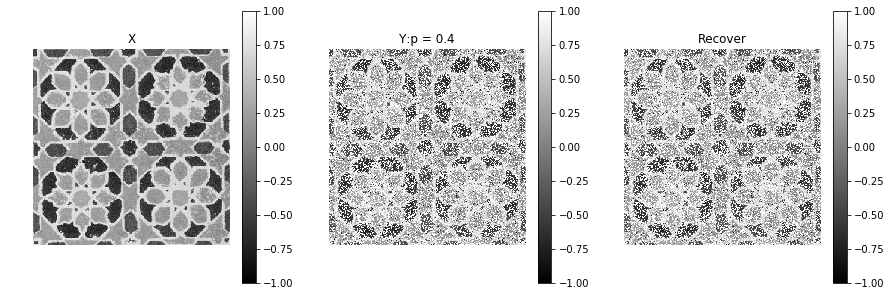

0.5


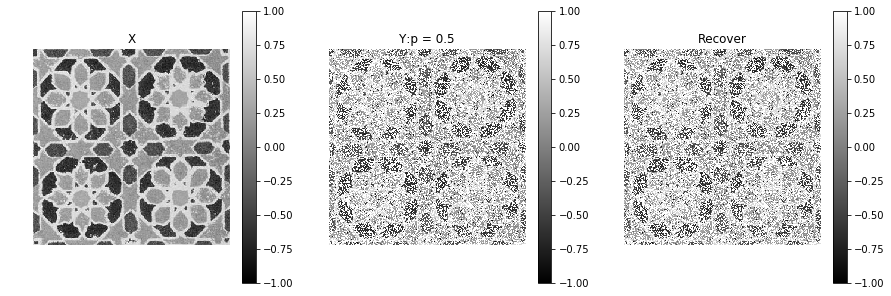

1


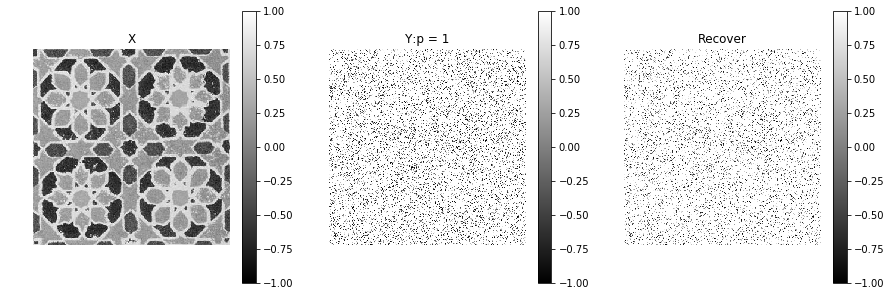

1.5


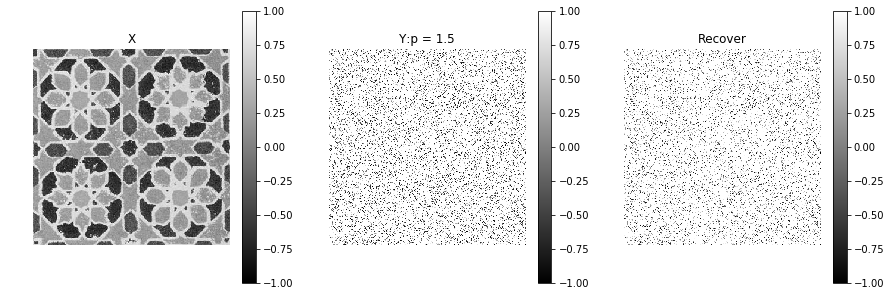

2


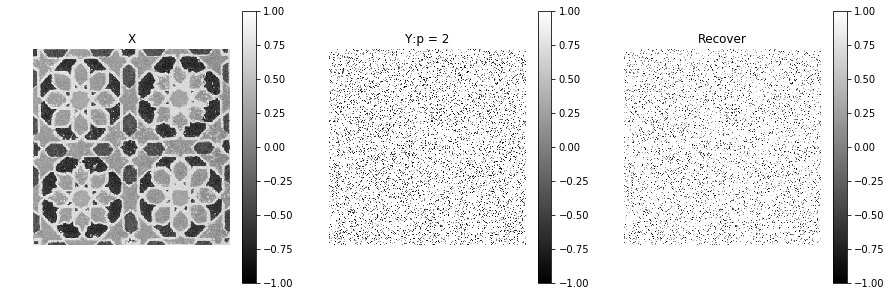

5


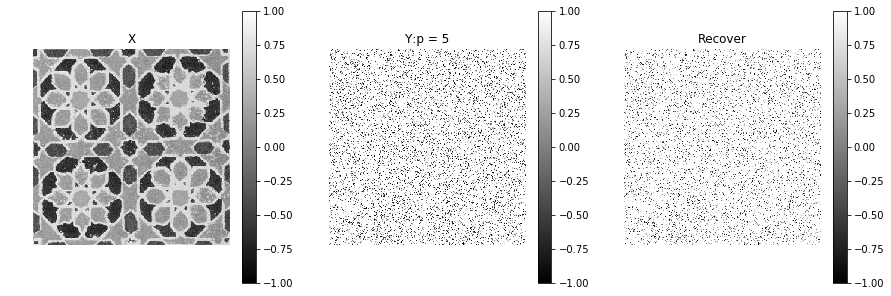

In [118]:
for p in [0.01,0.1,0.2,0.4,0.5,1,1.5,2,5]:
    print(p)
    X = read_img(2)
    m,n = X.shape
#     p = 0.1
    mask = np.random.rand(m,n) <= p
    Y = X.copy()
    Y[mask] = 5*np.random.rand(np.count_nonzero(mask))


    # Center image around 0

    X = (X-0.5)/0.5
    Y = (Y-0.5)/0.5
    L,S = robust_PCA(Y,1,0.08,1000)
    plt.figure(figsize = (15,5))
    plt.subplot(1,3,1), plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
    plt.title('X');
    plt.subplot(1,3,2), plt.imshow(Y, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
    plt.title('Y:p = '+str(p));
    plt.subplot(1,3,3), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
    plt.title('Recover');
    plt.show()

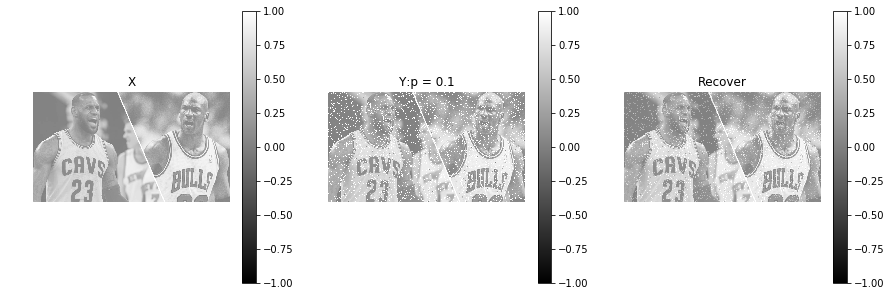

In [125]:
image = matplotlib.pyplot.imread('texture_matfiles/split-lebron-james-michael-jordan-042116-getty-ftrjpg_qd6jxqonn9wm1oo8e0v4ukqhy.jpg')
X = skimage.color.rgb2gray(image)
m,n = X.shape
p = 0.1
mask = np.random.rand(m,n) <= p
Y = X.copy()
Y[mask] = 5*np.random.rand(np.count_nonzero(mask))
L,S = robust_PCA(Y,1,0.08,1000)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1), plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('X');
plt.subplot(1,3,2), plt.imshow(Y, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Y:p = '+str(p));
plt.subplot(1,3,3), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Recover');
plt.show()

__(e)__ Try loading in your own image with a different texture.  Does this work for more natural objects/images?  Why or why not?  

## Part 2 - Bonus Questions

Implement an algorithm of your choice for low-rank matrix recovery, robust PCA, or dictionary learning and/or apply this to an application of your choice.

Some ideas:

* Extend the low rank texture recovery to work for shifts/scaling, as discussed in Ch. 14
* Use robust PCA on a video or other problem 
* Code up a simple dictionary learning algorithm, like K-SVD 
* Anything else!  

Have fun!  


Here we wants to implement robust PCA to medical images like MRI

In [127]:
data = np.load('brain.npz')
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'],

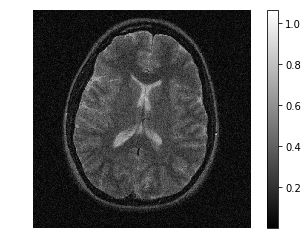

In [147]:
def fft2c(x):
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

def ifft2c(y):
    return np.sqrt(np.prod(y.shape)) * np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))
M = fft2c(im);
M2 = (M * mask_vardens)/ pdf_vardens;
X = abs(ifft2c(M2))
plt.imshow(X, cmap = 'gray'); plt.axis('off'), plt.colorbar(); 

In [148]:
X = (X-0.5)/0.5
L,S = robust_PCA(X,1,0.05,1000)

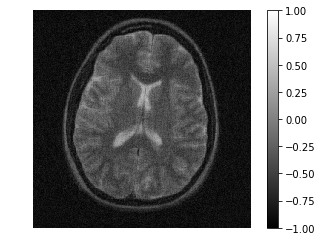

In [149]:
plt.imshow(L, cmap = 'gray',vmin=-1,vmax=1); plt.axis('off'), plt.colorbar(); 